# Multi-Class SVC 

### Introduction

In its most basic form SVC is a binary classifier. However, many binary classification are only a subset of the typical classification problems encountered in practice. It is easy to generalise the base SVC model into a multi-class classifier. There are two common approaches to this: OvO (One-vs-One) and OvR (One-vs-the-rest). Let us discuss these methods from a high-level overview, 

- **OvR**: OvR is short for _"One-vs-the-rest"_. In this approach, a binary classifier is made for each class label. Let us say that we have $M$ of classes, in OvR we create $M$ number of binary classifiers for each class label. When training each classifier, we re-label our data points so that positive class $1$ belongs to our choosen class $k$ and our negative class $0$ includes data points of all other classes. Mathematically,

$$
y_i^{(k)} = \begin{cases} +1, & y_i = k, \\ 0, & y_i \neq k. \end{cases}
$$

And so each SVM is trained to classify $y_i = k$ from $y_i \neq k$

- **OvO**:

### OvR Implementation

In OvR, the final class prediction for a given sample $X_i$ is determined from the BaseSVC whose decision function $f_k(X_i)$ is the largest. Note that $k$ denotes the $k$-th class label. We can imagine $f_k(X_i) = X_iW^T_{(k)} + b_{(k)}$ as a measure of how strongly a sample belongs to the class $k$. Mathematically,

$$
\hat{y} = \text{argmax}_k \quad f_k(X_i)
$$

where $\hat{y}$ is our predicted class label.

In [12]:
# Importing,
import numpy as np
from models.BaseSVM import BaseSVC
from joblib import Parallel, delayed

class SVC():
    """This is the class for the support vector classifier with multi-class support using a OvR approach."""

    def __init__(self, C=1):
        """Constructor method."""

        # Hyperparameters,
        self.C = C

        # Class attributes,
        self.class_labels, self.n_labels = None, None
        self.model_score = None

        # Stores all base SVC models,
        self.base_clfs = []

    def fit(self, X, y, n_jobs=-1):
        """DocString to be filled out."""

        # Extracting class labels,
        self.class_labels = np.unique(y)
        self.n_labels = len(self.class_labels)

        # Fitting BaseSVCs in parallel,
        self.base_clfs = Parallel(n_jobs=n_jobs)(
            delayed(self._fit_baseSVC)(X, y, class_label) for class_label in self.class_labels
            )

    def predict(self, X):
        """DocString to be filled out."""

        # Creating prediction matrix,
        preds_matrix = np.zeros(shape=(self.n_labels, X.shape[0]))
        for i, clf in enumerate(self.base_clfs):
            preds = clf._decision_function(X)
            preds_matrix[i] = preds

        # Returning predictions,
        preds = np.zeros(shape=X.shape[0], dtype=int)

        for i, base_preds in enumerate(preds_matrix.T):
            label_pred = np.argmax(base_preds)
            preds[i] = label_pred

        return preds
    
    def score(self, X, y):
        """Returns the classification accuracy on the supplied dataset."""

        # Calculating model predictions,
        y_preds = self.predict(X)

        # Computing classification accuracy,
        self.model_score = np.mean(y_preds == y)

        return self.model_score

    def _fit_baseSVC(self, X, y, class_label):
        """Helper function for fitting a BaseSVC model."""

        # Finding class labels,
        class_idxs = np.where(y == class_label)[0]
        class_comp_idxs = np.where(y != class_label)[0] # <-- The compliment.

        # Re-labeling class labels,
        X_class, y_class = X[class_idxs], np.ones(shape=len(class_idxs))
        X_class_comp, y_class_comp = X[class_comp_idxs], np.zeros(shape=len(class_comp_idxs))

        # Combining and splitting,
        X_new = np.concatenate((X_class, X_class_comp), axis=0)
        y_new = np.concatenate((y_class, y_class_comp), axis=0)

        # Training BaseSVM model,
        clf = BaseSVC(C=self.C)
        clf.fit(X_new, y_new)

        return clf

### Basic Example

Let us test our OvR implemenation a toy dataset. In our example, we choose the wine dataset available at https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data and documented in https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-dataset.

In [13]:
# Importing dataset,
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# Creating data split,
wine_dataset = load_wine()
X, y = wine_dataset["data"], wine_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Training model,
clf = SVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9722222222222222

Comparing our model to the Sci-learn implementation,

In [14]:
# Importing,
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC as SKSVC

# Training model,
sk_clf = OneVsRestClassifier(SKSVC()) # <-- OvR scheme is a wrapper around the base model.
sk_clf.fit(X_train, y_train)
sk_clf.score(X_test, y_test)

0.8333333333333334

### Digit Recognition

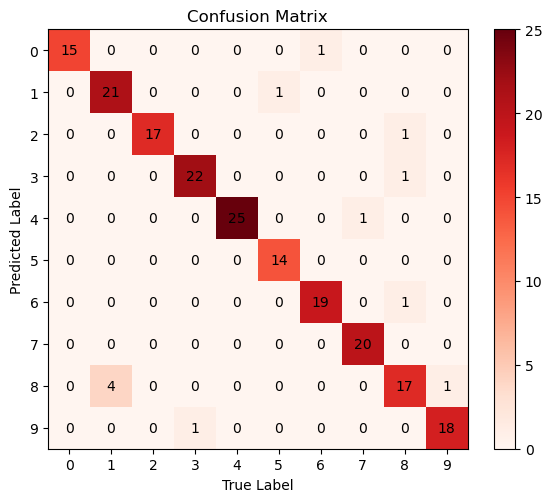

Classification Accuracy: 0.940
β: 1

Class        Precision    Recall  Fβ-score   Support
----------------------------------------------------
0                0.938     1.000     0.938        15
1                0.955     0.840     0.955        25
2                0.944     1.000     0.944        17
3                0.957     0.957     0.957        23
4                0.962     1.000     0.962        25
5                1.000     0.933     1.000        15
6                0.950     0.950     0.950        20
7                1.000     0.952     1.000        21
8                0.773     0.850     0.773        20
9                0.947     0.947     0.947        19
----------------------------------------------------
Average              0.942     0.943     0.942
Weighted-average     0.942     0.940     0.942


In [10]:
# Importing dataset,
from sklearn.datasets import load_digits
from utils.ConfusionMatrix import ConfusionMatrix, PlotConfusionMatrix # <-- Our implementation.

# Creating data split,
digit_dataset = load_digits()
X, y = digit_dataset["data"][0:1000], digit_dataset["target"][0:1000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Training model,
clf = SVC()
clf.fit(X_train, y_train)

# Creating confusion matrix,
conf_matrix = ConfusionMatrix(clf, X_test, y_test)
PlotConfusionMatrix(conf_matrix)
conf_matrix.report()

We see a major difference in speed with the Sci-kit implementation,

0.98


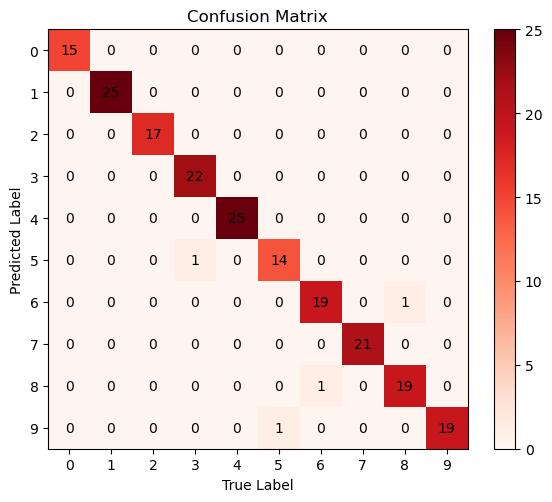

Classification Accuracy: 0.980
β: 1

Class        Precision    Recall  Fβ-score   Support
----------------------------------------------------
0                1.000     1.000     1.000        15
1                1.000     1.000     1.000        25
2                1.000     1.000     1.000        17
3                1.000     0.957     1.000        23
4                1.000     1.000     1.000        25
5                0.933     0.933     0.933        15
6                0.950     0.950     0.950        20
7                1.000     1.000     1.000        21
8                0.950     0.950     0.950        20
9                0.950     1.000     0.950        19
----------------------------------------------------
Average              0.978     0.979     0.978
Weighted-average     0.980     0.980     0.980


In [11]:
# Training model,
sk_clf = OneVsRestClassifier(SKSVC()) # <-- OvR scheme is a wrapper around the base model.
sk_clf.fit(X_train, y_train)
sk_clf.score(X_test, y_test)

# Creating confusion matrix,
conf_matrix = ConfusionMatrix(sk_clf, X_test, y_test)
print(conf_matrix.accuracy())
PlotConfusionMatrix(conf_matrix)
conf_matrix.report()